implementation of assignment and solutions to problems: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/2_fullyconnected.ipynb

Assignment 2
---------

Previously in 1_notmnist.ipynb, we created a pickle with formatted datasets for training, development and testing on the notMNIST dataset.

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.


In [137]:
import numpy as np
import tensorflow as tf
import cPickle as pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [65]:
PKL_FILE = 'notMNIST.pickle'
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_PIXELS = IMG_HEIGHT * IMG_WIDTH
NUM_CLASSES = 10

In [66]:

with open(PKL_FILE, 'rb') as f:
    save_file = pickle.load(f)
    train_dataset = save_file['train_dataset']
    train_labels  = save_file['train_labels']
    test_dataset  = save_file['test_dataset']
    test_labels   = save_file['test_labels']
    val_dataset   = save_file['valid_dataset']
    val_labels    = save_file['valid_labels']
    
    del save_file
    
print 'Training', train_dataset.shape, train_labels.shape
print 'Test', test_dataset.shape, test_labels.shape
print 'Validation', val_dataset.shape, val_labels.shape

def reformat_dataset(dataset):
    return dataset.reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32)

def one_hot_encode(labels):
    if(len(labels.shape) > 1):
        raise Exception('labels should be a vector')
    return (np.arange(NUM_CLASSES) == labels.reshape(-1, 1)).astype(np.float32)

train_dataset = reformat_dataset(train_dataset)
train_labels  = one_hot_encode(train_labels)
test_dataset  = reformat_dataset(test_dataset)
test_labels   = one_hot_encode(test_labels)
val_dataset   = reformat_dataset(val_dataset)
val_labels    = one_hot_encode(val_labels)

print 'Training', train_dataset.shape, train_labels.shape
print 'Test', test_dataset.shape, test_labels.shape
print 'Validation', val_dataset.shape, val_labels.shape


Training (200000, 28, 28) (200000,)
Test (10000, 28, 28) (10000,)
Validation (10000, 28, 28) (10000,)
Training (200000, 784) (200000, 10)
Test (10000, 784) (10000, 10)
Validation (10000, 784) (10000, 10)


Multinomial Logistic Regression
-----------

We're first going to train a multinomial logistic regression using simple gradient descent.


In [67]:
train_subset = 10000
graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_test_dataset = tf.constant(test_dataset)
    tf_val_dataset = tf.constant(val_dataset)
    
    #weights matrix
    #initialized as a set of random results 
    #train weights to predict the log probability for each of the clases based on the
    #for each class - sigmoid(w1*x1 + w2*x2 + .... + wN * xN + b)
    
    weights = tf.Variable(tf.truncated_normal( shape = (IMG_PIXELS, NUM_CLASSES)))
    biases = tf.Variable(tf.zeros([NUM_CLASSES]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) 
    opt = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_predictions = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_val_dataset, weights) + biases)
    test_prediction  = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 
    

In [93]:
training_steps = 801

acc = lambda preds, labels : np.sum(np.argmax(preds, 1) == np.argmax(labels, 1))/float(preds.shape[0])
training_acc = []
validation_acc = []
start = time.time()
with tf.Session(graph = graph) as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    for step in range(training_steps):
        _, loss_score, pred = sess.run([opt, loss, train_predictions])
        train_acc = acc(pred, tf_train_labels.eval())
        val_acc = acc(valid_prediction.eval(), val_labels)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        if step % 50 == 0:
            print 'Loss at step: ', step, loss_score,
            print 'Train Acc', train_acc, #biased
            print 'Valid Acc', val_acc
    print 'Test Accuracy', acc(test_prediction.eval(), test_labels)
print 'Runtime', time.time() - start

Loss at step:  0 17.1443 Train Acc 0.0993 Valid Acc 0.1273
Loss at step:  50 2.9168 Train Acc 0.6562 Valid Acc 0.6463
Loss at step:  100 2.31434 Train Acc 0.7112 Valid Acc 0.6944
Loss at step:  150 2.02989 Train Acc 0.7329 Valid Acc 0.7144
Loss at step:  200 1.84387 Train Acc 0.7448 Valid Acc 0.7258
Loss at step:  250 1.70552 Train Acc 0.7539 Valid Acc 0.7318
Loss at step:  300 1.59633 Train Acc 0.7601 Valid Acc 0.7355
Loss at step:  350 1.50721 Train Acc 0.7666 Valid Acc 0.738
Loss at step:  400 1.43254 Train Acc 0.7731 Valid Acc 0.7388
Loss at step:  450 1.36861 Train Acc 0.7767 Valid Acc 0.7406
Loss at step:  500 1.31293 Train Acc 0.7792 Valid Acc 0.7426
Loss at step:  550 1.26375 Train Acc 0.7819 Valid Acc 0.7435
Loss at step:  600 1.21982 Train Acc 0.7837 Valid Acc 0.7448
Loss at step:  650 1.1802 Train Acc 0.7876 Valid Acc 0.7468
Loss at step:  700 1.1442 Train Acc 0.7908 Valid Acc 0.7483
Loss at step:  750 1.11128 Train Acc 0.7925 Valid Acc 0.7491
Loss at step:  800 1.08099 Trai

In [101]:
batch_size = 128
minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (batch_size, NUM_CLASSES))
    tf_test_dataset = tf.constant(test_dataset)
    tf_val_dataset = tf.constant(val_dataset)
    
    #weights matrix
    #initialized as a set of random results 
    #train weights to predict the log probability for each of the clases based on the
    #for each class - sigmoid(w1*x1 + w2*x2 + .... + wN * xN + b)
    
    weights = tf.Variable(tf.truncated_normal( shape = (IMG_PIXELS, NUM_CLASSES)))
    biases = tf.Variable(tf.zeros([NUM_CLASSES]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) 
    opt = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_predictions = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_val_dataset, weights) + biases)
    test_prediction  = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 
    

In [105]:
training_steps = 1501
train_dataset_size = train_dataset.shape[0]

training_hist = []
validation_hist = []
loss_hist = []
start = time.time()
with tf.Session(graph = minibatch_graph) as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    for step in range(training_steps):
        sample = np.random.choice(np.arange(train_dataset_size), 128)
        data_batch = train_dataset[sample]
        label_batch = train_labels[sample]
        _, loss_score, pred = sess.run([opt, loss, train_predictions], feed_dict = {tf_train_dataset : data_batch,
                                                                                    tf_train_labels  : label_batch
                                                                                   })
        train_acc = acc(pred, label_batch)
        val_acc = acc(valid_prediction.eval(), val_labels)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        loss_hist.append(loss_score)
        if step % 50 == 0:
            print 'Loss at step: ', step, loss_score,
            print 'Train Acc', train_acc, #biased
            print 'Valid Acc', val_acc
    print 'Test Accuracy', acc(test_prediction.eval(), test_labels)
print 'Runtime', time.time() - start

Loss at step:  0 17.2023 Train Acc 0.0625 Valid Acc 0.0948
Loss at step:  50 2.75855 Train Acc 0.6484375 Valid Acc 0.6616
Loss at step:  100 1.95608 Train Acc 0.6796875 Valid Acc 0.7143
Loss at step:  150 2.23437 Train Acc 0.734375 Valid Acc 0.7322
Loss at step:  200 2.07224 Train Acc 0.7578125 Valid Acc 0.7398
Loss at step:  250 2.35143 Train Acc 0.7109375 Valid Acc 0.7443
Loss at step:  300 1.41116 Train Acc 0.8515625 Valid Acc 0.7476
Loss at step:  350 1.8085 Train Acc 0.71875 Valid Acc 0.7538
Loss at step:  400 1.44126 Train Acc 0.765625 Valid Acc 0.753
Loss at step:  450 1.31516 Train Acc 0.734375 Valid Acc 0.7564
Loss at step:  500 1.85536 Train Acc 0.703125 Valid Acc 0.7555
Loss at step:  550 2.07593 Train Acc 0.7109375 Valid Acc 0.7583
Loss at step:  600 1.09346 Train Acc 0.7890625 Valid Acc 0.7545
Loss at step:  650 1.52374 Train Acc 0.7265625 Valid Acc 0.7601
Loss at step:  700 1.8009 Train Acc 0.6796875 Valid Acc 0.7582
Loss at step:  750 1.61678 Train Acc 0.7421875 Valid Ac

In [106]:
plt.plot(loss_hist)
plt.show()

---------
Problem
-------
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. This model should improve your validation / test accuracy.

In [146]:
batch_size = 128
num_hidden_nodes = 1024
minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))
    tf_test_dataset = tf.constant(test_dataset)
    tf_val_dataset = tf.constant(val_dataset)
    
    #weights matrix
    #initialized as a set of random results 
    #train weights to predict the log probability for each of the clases based on the
    #for each class - sigmoid(w1*x1 + w2*x2 + .... + wN * xN + b)
    
    w1 = tf.get_variable("W1", shape = (IMG_PIXELS, 1024), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [1024], mean = 0.1, stddev=0.05))
    #w1 = tf.Variable(tf.truncated_normal( shape = (IMG_PIXELS, 1024)))
    #b1 = tf.Variable(tf.zeros([1024]))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    
    w2 = tf.get_variable("W2", shape = (1024, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    #w2 = tf.Variable(tf.truncated_normal( shape = (1024, NUM_CLASSES)))
    #b2 = tf.Variable(tf.zeros([NUM_CLASSES]))
    logits = tf.matmul(h1, w2) + b2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) 
    opt = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    predictions = tf.nn.softmax(logits)
    

In [147]:
training_steps = 3500
train_dataset_size = train_dataset.shape[0]

training_hist = []
validation_hist = []
loss_hist = []
start = time.time()
with tf.Session(graph = minibatch_graph) as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    for step in range(training_steps):
        sample = np.random.choice(np.arange(train_dataset_size), 128)
        data_batch = train_dataset[sample]
        label_batch = train_labels[sample]
        _, loss_score, pred = sess.run([opt, loss, predictions], feed_dict = {tf_train_dataset : data_batch,
                                                                                    tf_train_labels  : label_batch
                                                                                   })
        if step % 50 == 0:
            print 'Loss at step: ', step, loss_score,
            print 'Train Acc', train_acc, #biased
            print 'Valid Acc', val_acc
            print 'Elapsed Time', time.time() - start
            
            #log results
            valid_pred = sess.run(predictions, feed_dict = {tf_train_dataset : val_dataset})
            train_acc = acc(pred, label_batch)
            val_acc = acc(valid_pred, val_labels)
            training_hist.append(train_acc)
            validation_hist.append(val_acc)
            loss_hist.append(loss_score)
        
    test_pred = sess.run(predictions, feed_dict = {tf_train_dataset : test_dataset})    
    print 'Test Accuracy', acc(test_pred, test_labels)
print 'Runtime', time.time() - start

Loss at step:  0 2.43762 Train Acc 0.90625 Valid Acc 0.8645
Elapsed Time 0.237092018127
Loss at step:  50 0.803512 Train Acc 0.0625 Valid Acc 0.3158
Elapsed Time 1.55342411995
Loss at step:  100 0.706652 Train Acc 0.78125 Valid Acc 0.8062
Elapsed Time 2.83118104935
Loss at step:  150 0.494457 Train Acc 0.8046875 Valid Acc 0.8151
Elapsed Time 4.11843705177
Loss at step:  200 0.666156 Train Acc 0.8515625 Valid Acc 0.823
Elapsed Time 5.42649316788
Loss at step:  250 0.631942 Train Acc 0.796875 Valid Acc 0.8263
Elapsed Time 6.69212317467
Loss at step:  300 0.596063 Train Acc 0.8359375 Valid Acc 0.8302
Elapsed Time 7.99749612808
Loss at step:  350 0.515667 Train Acc 0.8359375 Valid Acc 0.8283
Elapsed Time 9.24721097946
Loss at step:  400 0.407151 Train Acc 0.859375 Valid Acc 0.8376
Elapsed Time 10.533064127
Loss at step:  450 0.586637 Train Acc 0.8984375 Valid Acc 0.8365
Elapsed Time 11.8072650433
Loss at step:  500 0.555998 Train Acc 0.859375 Valid Acc 0.8384
Elapsed Time 13.1273970604
Los

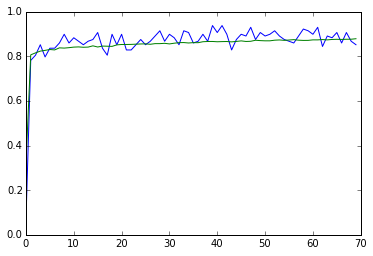

In [148]:
plt.plot(training_hist)
plt.plot(validation_hist)
plt.show()

----------
Same Architecture as above using Adam with default settings
--------
----------

In [152]:
batch_size = 128
num_hidden_nodes = 1024
minibatch_graph = tf.Graph()
with minibatch_graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (None, IMG_PIXELS))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (None, NUM_CLASSES))
    tf_test_dataset = tf.constant(test_dataset)
    tf_val_dataset = tf.constant(val_dataset)
    
    #weights matrix
    #initialized as a set of random results 
    #train weights to predict the log probability for each of the clases based on the
    #for each class - sigmoid(w1*x1 + w2*x2 + .... + wN * xN + b)
    
    w1 = tf.get_variable("W1", shape = (IMG_PIXELS, 1024), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.truncated_normal(shape = [1024], mean = 0.1, stddev=0.05))
    #w1 = tf.Variable(tf.truncated_normal( shape = (IMG_PIXELS, 1024)))
    #b1 = tf.Variable(tf.zeros([1024]))
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    
    w2 = tf.get_variable("W2", shape = (1024, NUM_CLASSES), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.truncated_normal(shape = [NUM_CLASSES], mean = 0.1, stddev=0.05))
    #w2 = tf.Variable(tf.truncated_normal( shape = (1024, NUM_CLASSES)))
    #b2 = tf.Variable(tf.zeros([NUM_CLASSES]))
    logits = tf.matmul(h1, w2) + b2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) 
    opt = tf.train.AdamOptimizer().minimize(loss)
    
    predictions = tf.nn.softmax(logits)
    

training_steps = 3500
train_dataset_size = train_dataset.shape[0]

training_hist = []
validation_hist = []
loss_hist = []
start = time.time()
with tf.Session(graph = minibatch_graph) as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    for step in range(training_steps):
        sample = np.random.choice(np.arange(train_dataset_size), 128)
        data_batch = train_dataset[sample]
        label_batch = train_labels[sample]
        _, loss_score, pred = sess.run([opt, loss, predictions], feed_dict = {tf_train_dataset : data_batch,
                                                                                    tf_train_labels  : label_batch
                                                                                   })
        if step % 50 == 0:
            print 'Loss at step: ', step, loss_score,
            print 'Train Acc', train_acc, #biased
            print 'Valid Acc', val_acc
            print 'Elapsed Time', time.time() - start
            
            #log results
            valid_pred = sess.run(predictions, feed_dict = {tf_train_dataset : val_dataset})
            train_acc = acc(pred, label_batch)
            val_acc = acc(valid_pred, val_labels)
            training_hist.append(train_acc)
            validation_hist.append(val_acc)
            loss_hist.append(loss_score)
        
    test_pred = sess.run(predictions, feed_dict = {tf_train_dataset : test_dataset})    
    print 'Test Accuracy', acc(test_pred, test_labels)
print 'Runtime', time.time() - start

Loss at step:  0 2.37981 Train Acc 0.7265625 Valid Acc 0.6896
Elapsed Time 0.265480041504
Loss at step:  50 0.566345 Train Acc 0.125 Valid Acc 0.4657
Elapsed Time 1.61279296875
Loss at step:  100 0.482214 Train Acc 0.84375 Valid Acc 0.8183
Elapsed Time 2.94011211395
Loss at step:  150 0.705916 Train Acc 0.8359375 Valid Acc 0.8265
Elapsed Time 4.31871700287
Loss at step:  200 0.508679 Train Acc 0.8125 Valid Acc 0.8355
Elapsed Time 5.74705004692
Loss at step:  250 0.533054 Train Acc 0.875 Valid Acc 0.8359
Elapsed Time 7.3564221859
Loss at step:  300 0.44953 Train Acc 0.8515625 Valid Acc 0.8386
Elapsed Time 8.77124714851
Loss at step:  350 0.37928 Train Acc 0.859375 Valid Acc 0.8483
Elapsed Time 10.161080122
Loss at step:  400 0.385821 Train Acc 0.8671875 Valid Acc 0.8377
Elapsed Time 11.5672860146
Loss at step:  450 0.631951 Train Acc 0.8828125 Valid Acc 0.8504
Elapsed Time 13.1315760612
Loss at step:  500 0.549704 Train Acc 0.8125 Valid Acc 0.8534
Elapsed Time 14.5584771633
Loss at step